Alexander W. Criswell 10/10/25

The mixed-move approach is now working well enough that I'm seeing issues with the sampler trying to match to the spikiness of the data spectrum at higher frequencies, but fundamentally being unable to without improvements that we intend to do down the line (per-frequency parameterization of $\lambda_f$ and $N_f$, per-frequency uncertainty, etc.) This will interfere with our ability to make sure the initial toy model works as it currently exists. A few options to deal with this:

- Apply some sort of smoothing filter to the data spectrum to reduce spikiness. This may have the inadvertant effect of biasing the analysis towards populations with smoother spectra (i.e. fewer subthreshold sources), but this should at least partially be balanced out by the $N_{res}$ Poisson term.
- Dive right in and implement the above changes right now
- Further reduce the frequency range we consider, cutting out the problem area entirely.

This prototype notebook takes the latter approach.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cupy as xp
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
from matplotlib.pyplot import cycler
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.collections import LineCollection
import matplotlib.cm
from matplotlib import patches
# import jax.numpy as jnp
# import jax; jax.config.update("jax_enable_x64", True)
from corner import corner, overplot_lines
import legwork as lw
import astropy.units as u
from tqdm import tqdm
from math import factorial
plt.style.use('default')

In [3]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove, DistributionGenerate, MTDistGenMove
from eryn.utils.utility import groups_from_inds
from multiprocessing import Pool

In [4]:
def get_cycle(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = plt.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cycler("color",cmap(ind))
    else:
        colors = cmap(np.linspace(0,1,N))
        return cycler("color",colors)

In [5]:
default_cycler=cycler(color=['mediumorchid','teal','navy','firebrick','goldenrod','slategrey'])
plt.rc('axes', prop_cycle=default_cycler)

In [6]:
xp.cuda.is_available()

True

In [7]:
## set environment variables
import os
os.environ['PELARGIR_GPU'] = '1'
os.environ['SCIPY_ARRAY_API'] = '1'
os.environ['PELARGIR_ERYN'] = '1'

In [8]:
if os.environ['PELARGIR_GPU']:
    print('GPU enabled.')

GPU enabled.


In [9]:
import sys
prop_path = '/home/awc/Documents/LISA/projects/lisa_population_inference/pelargir-gb/pelargir/'
sys.path.insert(1, prop_path)
from models import PopModel
from inference import GalacticBinaryPrior, PopulationHyperPrior
from utils import get_amp_freq, lisa_noise_psd
import distributions as st

GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.


In [10]:
test_rng = xp.random.default_rng(170817)

In [11]:
test_prior = GalacticBinaryPrior(test_rng)

In [12]:
pop_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}
test_prior.condition(pop_theta)

In [13]:
samps = test_prior.sample_conditional(int(1e7))

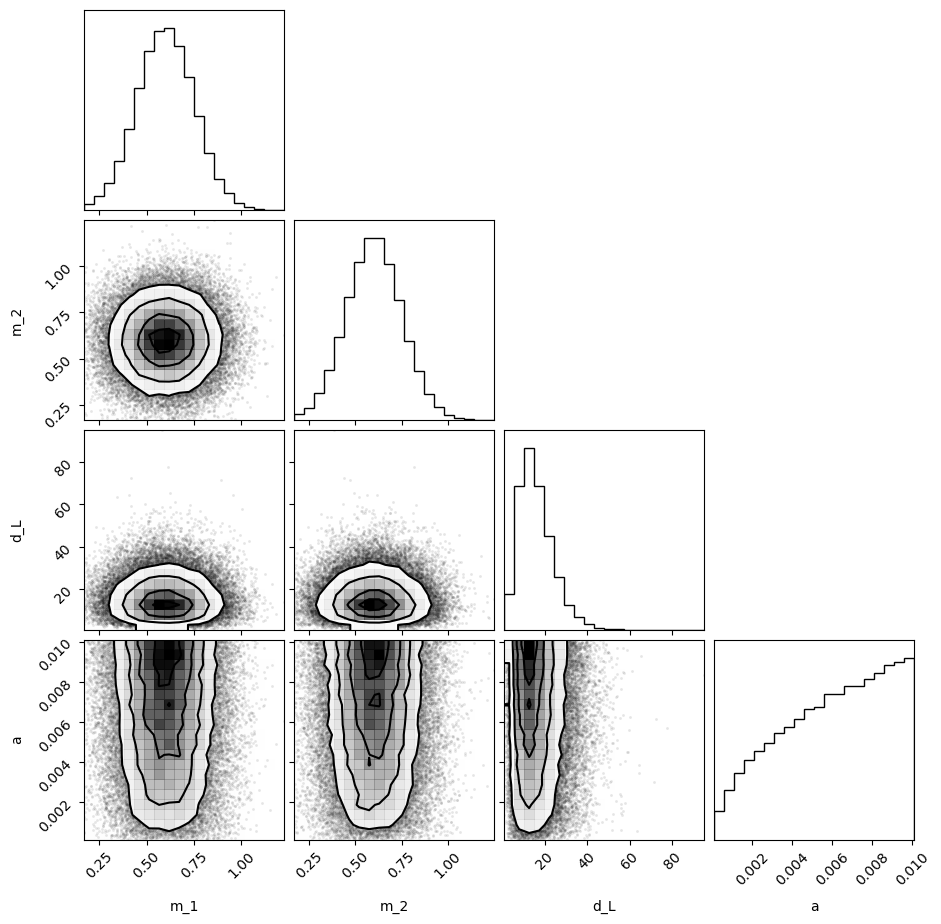

In [14]:
plt.close()
fig = corner(samps[:,::200].get().T,labels=list(test_prior.conditional_dict.keys()))
plt.show()

In [15]:
amps, fgws = get_amp_freq(samps)

In [16]:
test_hprior = PopulationHyperPrior(test_rng)

In [17]:
test_bin_width = 1e-5
test_fbins = xp.arange(3e-4,3e-3,test_bin_width)
test_popmodel = PopModel(1e7,test_rng,hyperprior=test_hprior,Nsamp=1,thresh_compute_frac=1.0,fbins=test_fbins)

In [18]:
test_f, test_fg, N_res = test_popmodel.run_model(pop_theta)

To compare to the initial population draw, we need to run the thresholder on it.

In [19]:
data_N_res, data_coarse_fg = test_popmodel.thresher.serial_array_sort(xp.array([fgws,amps]),
                                                                      test_popmodel.fbins,
                                                                      snr_thresh=test_popmodel.thresh_val,
                                                                      compute_frac=test_popmodel.tc_frac)
data_fg = test_popmodel.reweight_foreground(data_coarse_fg)[1:]

In [20]:
data_N_res

array(246)

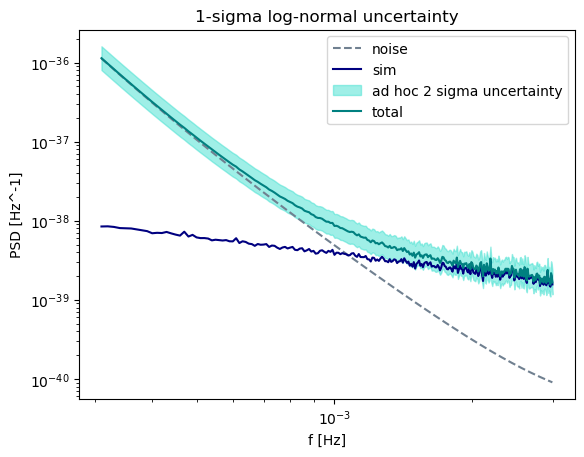

In [21]:
err = 0.075
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure()
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
# plt.fill_between(total_fs,total_spec-err,total_spec+err,
#                  color='turquoise',alpha=0.5,label='ad hoc 1 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('1-sigma log-normal uncertainty')
plt.show()

In [22]:
## setup w.r.t. the data
datadict = {'fg':data_fg,
            'fg_sigma':err, ## sigma_fg = 0.1 dex
            'Nres':data_N_res,
            'noise':lisa_noise_psd(test_f)}

In [23]:
test_rng = xp.random.default_rng(42)

In [24]:
translation_dict = {0:'m_mu',
                    1:'m_sigma',
                    2:'d_gamma_a',
                    3:'d_gamma_b',
                    4:'a_alpha'}
## starting with the broader priors
eryn_hyperprior_dict = {0:st.uniform(test_rng,loc=0.5,scale=0.2,cast=True),
                        1:st.invgamma(test_rng,5,cast=True),
                        2:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        3:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        4:st.uniform(test_rng,0.25,0.75,cast=True)}
eryn_trans_dict = {translation_dict[key]:eryn_hyperprior_dict[key] for key in eryn_hyperprior_dict.keys()}

In [25]:
eryn_trans_dict

{'m_mu': <distributions.uniform at 0x784e0a32eb40>,
 'm_sigma': <distributions.invgamma at 0x784e0a383e60>,
 'd_gamma_a': <distributions.uniform at 0x784e1000fa40>,
 'd_gamma_b': <distributions.uniform at 0x784e1000fa70>,
 'a_alpha': <distributions.uniform at 0x784e101c51c0>}

In [26]:
eryn_prior = ProbDistContainer(eryn_hyperprior_dict)

In [27]:
eryn_popmodel = PopModel(1e7,test_rng,hyperprior=eryn_trans_dict,fbins=test_fbins)

In [28]:
eryn_popmodel.construct_likelihood(datadict)

In [29]:
log_like_fn = eryn_popmodel.fg_N_ln_prob

In [30]:
ndim = len(eryn_popmodel.hyperprior.hyperprior_dict)
nwalkers = 10

In [31]:
## MH with prior draws as the proposal function
PriorMove = DistributionGenerate({'model_0':eryn_prior})

In [32]:
ensemble = EnsembleSampler(nwalkers,
                           ndim,
                           log_like_fn,
                           eryn_prior,
                           moves=[(StretchMove(),0.9),(PriorMove,0.1)],
                           track_moves=True,
                          )
                            # pool=pool)

In [33]:
# starting positions
# randomize throughout prior
coords = eryn_prior.rvs(size=(nwalkers,))
# print(coords[i],type(coords[i]))
# check log_like, forcing the initialization to have finite log likelihood
log_like=xp.empty(nwalkers)
for i in tqdm(range(nwalkers)):
    log_like[i] = log_like_fn(coords[i])
    while xp.isinf(log_like[i]):
        coords[i] = eryn_prior.rvs(1)
        log_like[i] = log_like_fn(coords[i])
# log_like = xp.asarray([
#     log_like_fn(coords[i])#, means, invcov)
# for i in range(nwalkers)])
print("Log-likelihood:\n", log_like)

# check log_prior
log_prior = xp.asarray([eryn_prior.logpdf(coords[i]) for i in range(nwalkers)])
print("\nLog-prior:\n", log_prior)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.23it/s]

Log-likelihood:
 [24076.37288934 20935.16840353 20074.71317653 22364.16767765
 11068.87551769 24047.12652127 23319.41699239 22026.36410337
 17915.70223462 21431.10556324]

Log-prior:
 [0.86118009 1.25089694 1.22826266 1.51522869 0.56837611 1.44484385
 1.33217912 1.55505861 1.53629572 1.57200972]


Let's look at the starting position...

In [34]:
coords

array([[0.67618726, 0.28312018, 4.28064498, 5.17473578, 0.3741182 ],
       [0.6227847 , 0.23563838, 5.47649775, 4.73237412, 0.72910914],
       [0.66626958, 0.2386487 , 2.77178007, 5.16601865, 0.71734289],
       [0.55094063, 0.14561032, 3.04252346, 2.96767457, 0.81804626],
       [0.65262744, 0.31612164, 3.64382533, 2.68287659, 0.31054369],
       [0.52553451, 0.20636006, 4.93586082, 3.27691628, 0.31611071],
       [0.54787632, 0.22431125, 4.33580204, 4.87389484, 0.45049512],
       [0.50098153, 0.18004956, 4.360787  , 4.46295561, 0.53078937],
       [0.57106973, 0.14962193, 5.33387367, 4.94635529, 0.81711396],
       [0.52909779, 0.16882218, 5.24072213, 4.83525325, 0.27514313]])

In [35]:
coords.shape

(10, 5)

In [36]:
## check intrinsic scatter in the likelihood?
starting_likes = []
starting_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(coords[i,:],return_spec=True)
    starting_likes.append(like_i)
    starting_astro.append(astro_i)

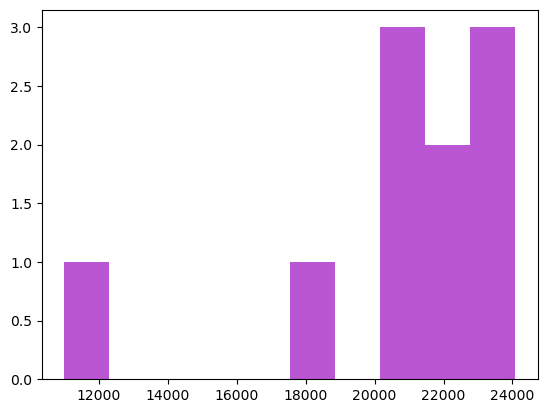

In [37]:
plt.figure()
plt.hist(starting_likes)
plt.show()

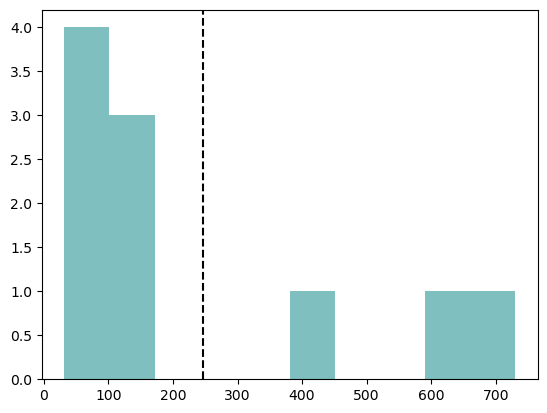

In [38]:
plt.figure()
plt.hist([starting_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

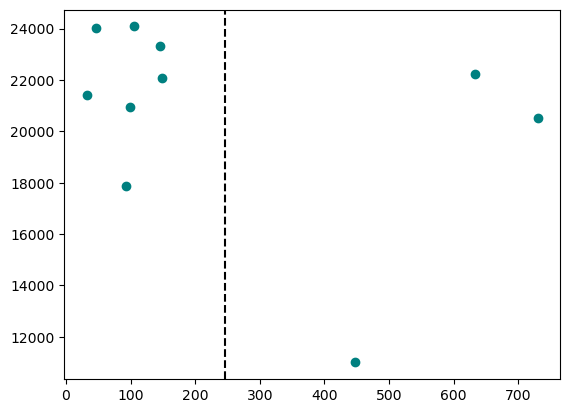

In [39]:
plt.figure()
plt.scatter([starting_astro[i][2] for i in range(nwalkers)],starting_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

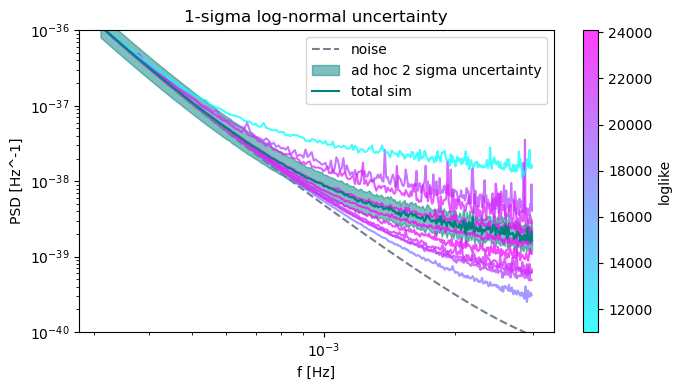

In [40]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(starting_astro[i][0], lisa_noise_psd(test_f).get()[1:]+starting_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([starting_astro[i][0], lisa_noise_psd(test_f).get()[1:]+starting_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=starting_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
                 color='teal',alpha=0.5,label='ad hoc 2 sigma uncertainty')
# plt.fill_between(total_fs,total_spec-err,total_spec+err,
#                  color='turquoise',alpha=0.5,label='ad hoc 1 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('1-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
# plt.xlim(5e-4,5e-3)
plt.tight_layout()
plt.show()

In [41]:
nsteps = 10
burn = None
thin_by = 1
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

  0%|                                                                                                                                                       | 0/10 [00:00<?, ?it/s]/home/awc/.local/share/mamba/envs/gwenv-1/lib/python3.12/site-packages/eryn/moves/move.py:421: RuntimeWarning: invalid value encountered in divide
  return self.accepted / self.num_proposals
 30%|██████████████████████████████████████████▉                                                                                                    | 3/10 [00:08<00:20,  2.96s/it]/home/awc/.local/share/mamba/envs/gwenv-1/lib/python3.12/site-packages/eryn/ensemble.py:1267: UserWarning: All points input for the Likelihood have a log prior of -inf.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.32s/it]


In [42]:
ensemble.get_log_like()

array([[[24074.61077662, 21185.47676453, 20277.98441383, 22298.59160159,
         20915.94709131, 24036.70448089, 24069.59335125, 22006.72491994,
         18764.54144628, 21470.40175156]],

       [[24078.49138256, 21185.47676453, 20277.98441383, 23780.21887626,
         20915.94709131, 24036.70448089, 24069.59335125, 22006.72491994,
         18764.54144628, 21614.36615469]],

       [[24078.49138256, 21243.37160638, 20277.98441383, 23780.21887626,
         20915.94709131, 24036.70448089, 24069.59335125, 22006.72491994,
         18764.54144628, 21794.22585087]],

       [[24078.49138256, 21243.37160638, 20277.98441383, 23780.21887626,
         20915.94709131, 24036.70448089, 24069.59335125, 22006.72491994,
         18764.54144628, 22825.13263496]],

       [[24078.49138256, 21243.37160638, 20277.98441383, 24051.56719747,
         21186.24052955, 24036.70448089, 24117.22215383, 22006.72491994,
         18764.54144628, 22825.13263496]],

       [[24078.49138256, 21322.21826168, 20277.984

In [43]:
ensemble.acceptance_fraction

array([[0.2, 0.4, 0. , 0.3, 0.4, 0.1, 0.2, 0.1, 0.1, 0.4]])

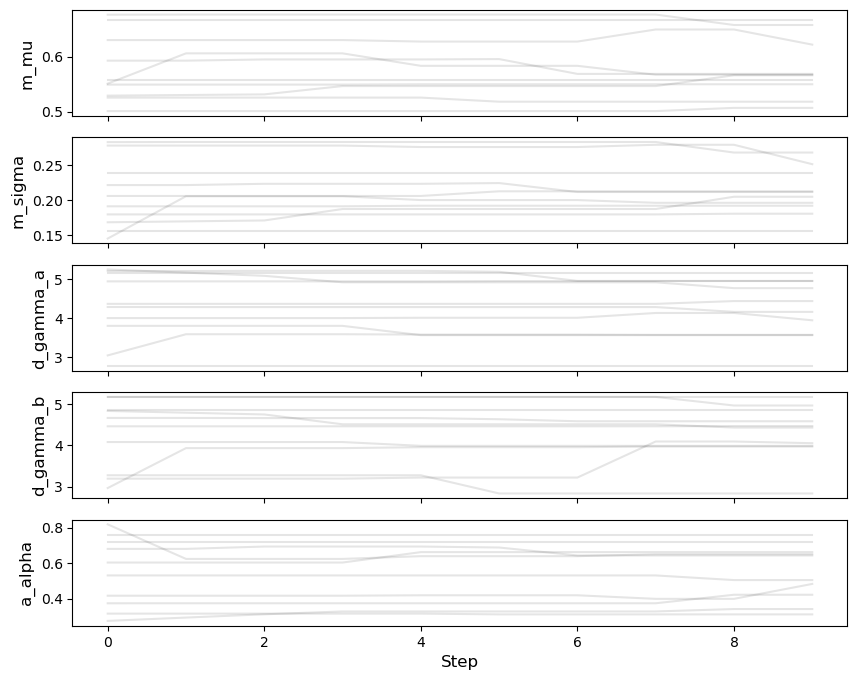

In [44]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

In [45]:
ensemble.get_chain()['model_0'].shape

(10, 1, 10, 1, 5)

In [46]:
# np.var(ensemble.get_chain()['model_0'].reshape(50,10,5),axis=0)

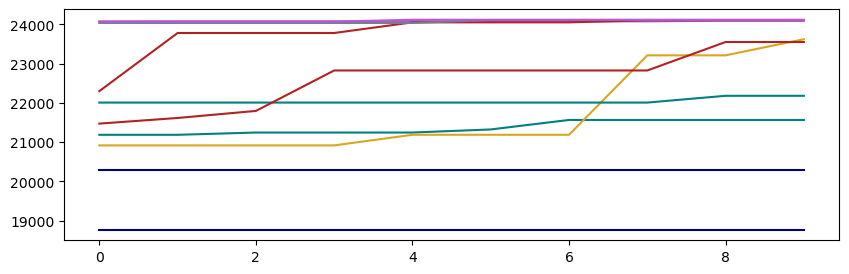

In [47]:
loglike = ensemble.get_log_posterior().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
# plt.ylim(-500,0)
plt.show()

Where are they now?

In [48]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)

In [49]:
## check intrinsic scatter in the likelihood?
current_likes = []
current_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(current_state[i,:],return_spec=True)
    current_likes.append(like_i)
    current_astro.append(astro_i)

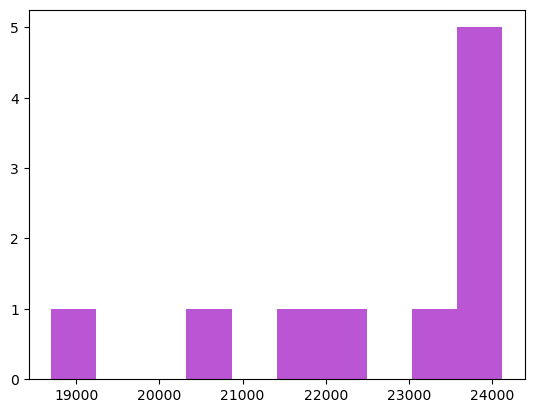

In [50]:
plt.figure()
plt.hist(current_likes)
plt.show()

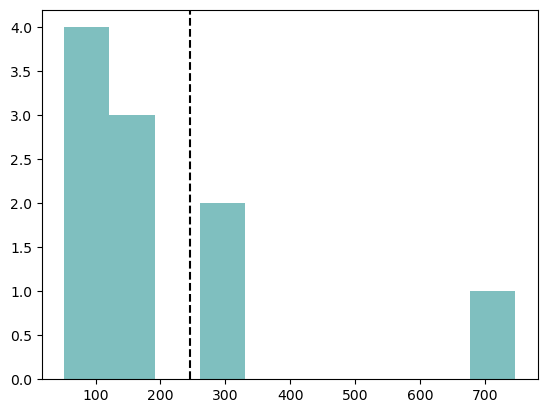

In [51]:
plt.figure()
plt.hist([current_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

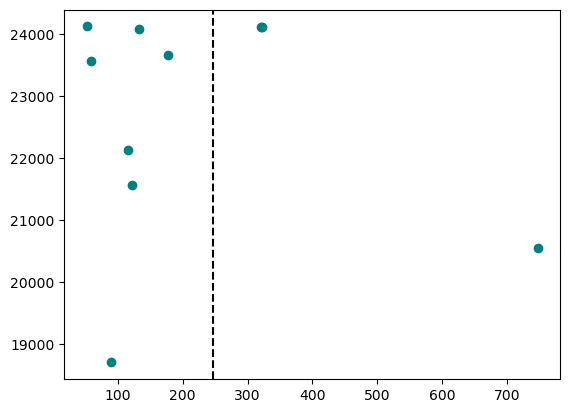

In [52]:
plt.figure()
plt.scatter([current_astro[i][2] for i in range(nwalkers)],current_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

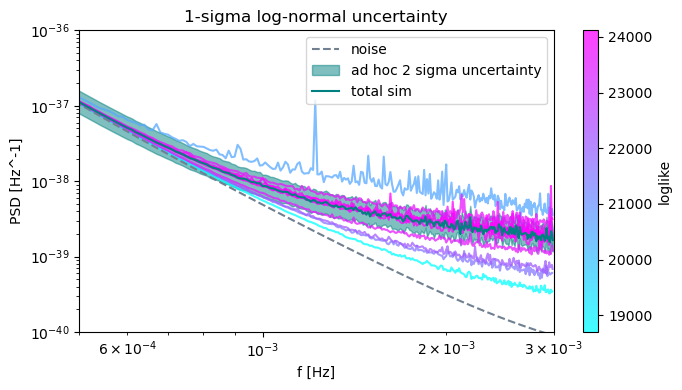

In [53]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=current_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
                 color='teal',alpha=0.5,label='ad hoc 2 sigma uncertainty')
# plt.fill_between(total_fs,total_spec-err,total_spec+err,
#                  color='turquoise',alpha=0.5,label='ad hoc 1 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('1-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
plt.xlim(5e-4,3e-3)
plt.tight_layout()
plt.show()

In [54]:
nsteps = 2000
burn = None
thin_by = 1
out = ensemble.run_mcmc(out, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [2:20:28<00:00,  4.21s/it]


In [55]:
ensemble.acceptance_fraction

array([[0.00597015, 0.0079602 , 0.00945274, 0.00646766, 0.00945274,
        0.00845771, 0.00845771, 0.00945274, 0.02039801, 0.01293532]])

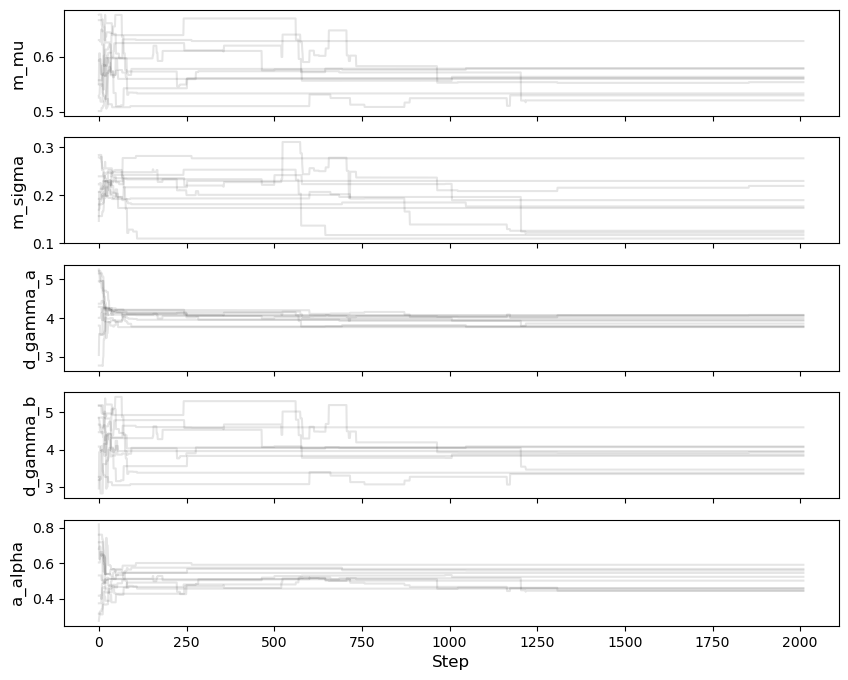

In [56]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

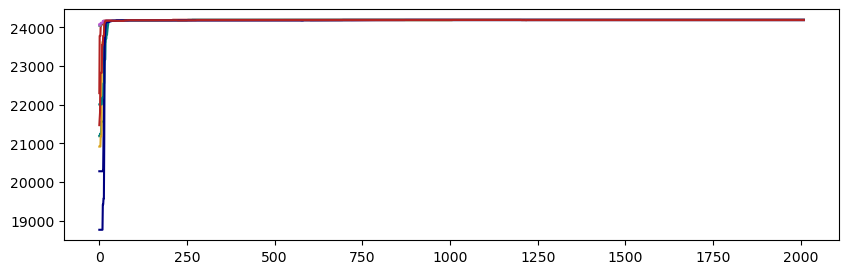

In [57]:
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
# plt.ylim(-500,0)
plt.show()

In [58]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)

In [59]:
## check intrinsic scatter in the likelihood?
current_likes = []
current_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(current_state[i,:],return_spec=True)
    current_likes.append(like_i)
    current_astro.append(astro_i)

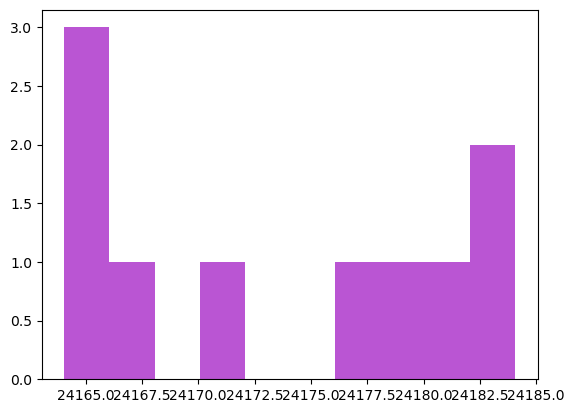

In [60]:
plt.figure()
plt.hist(current_likes)
plt.show()

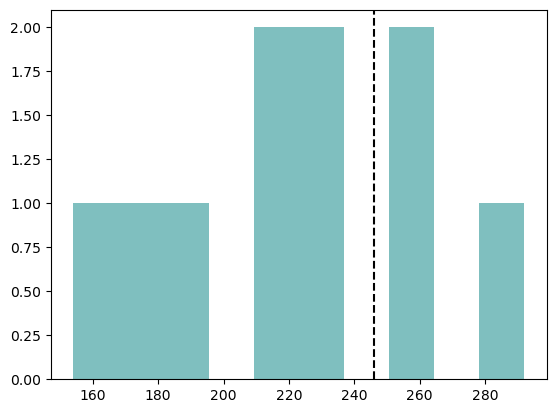

In [61]:
plt.figure()
plt.hist([current_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

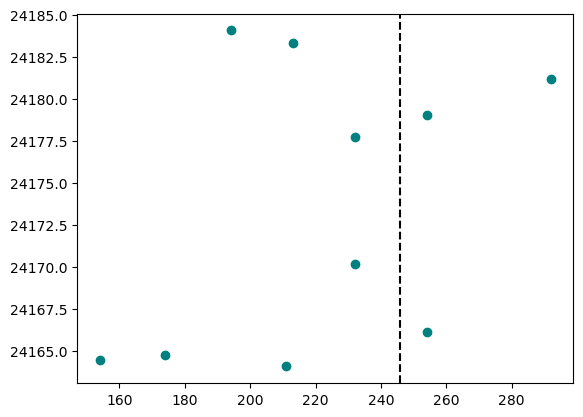

In [62]:
plt.figure()
plt.scatter([current_astro[i][2] for i in range(nwalkers)],current_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

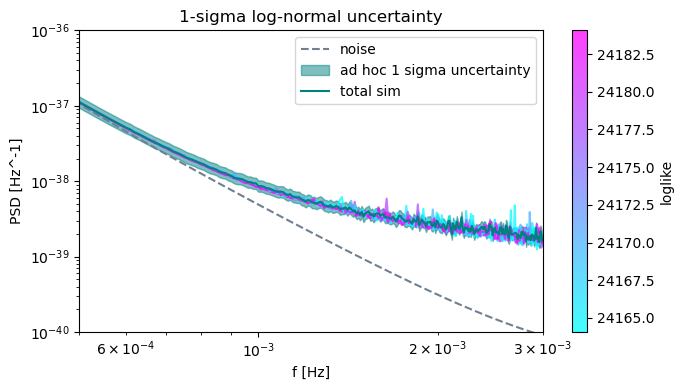

In [63]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=current_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
plt.fill_between(total_fs,10**(np.log10(total_spec)-err),10**(np.log10(total_spec)+err),
                 color='teal',alpha=0.5,label='ad hoc 1 sigma uncertainty')
# plt.fill_between(total_fs,total_spec-err,total_spec+err,
#                  color='turquoise',alpha=0.5,label='ad hoc 1 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('1-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
plt.xlim(5e-4,3e-3)
plt.tight_layout()
plt.show()

In [64]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [65]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

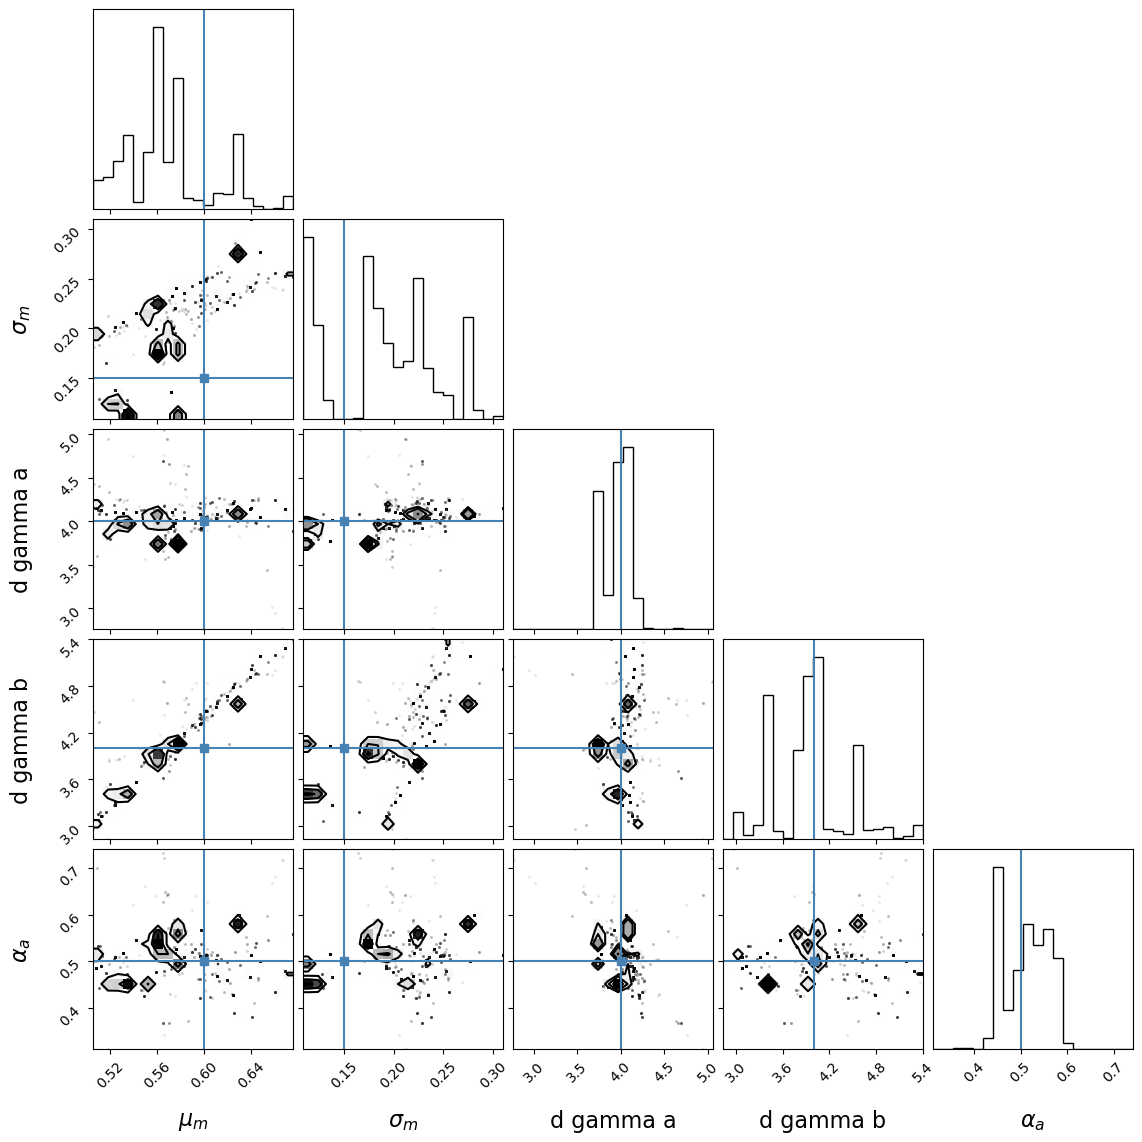

In [66]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)[100:,:]
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

In [102]:
nsteps = 200
burn = None
thin_by = 1
out = ensemble.run_mcmc(out, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

ValueError: The initial log_prior was NaN

In [97]:
ensemble.acceptance_fraction

array([[0.06451613, 0.09677419, 0.06129032, 0.09354839, 0.06451613,
        0.04516129, 0.03225806, 0.03548387, 0.08387097, 0.04193548]])

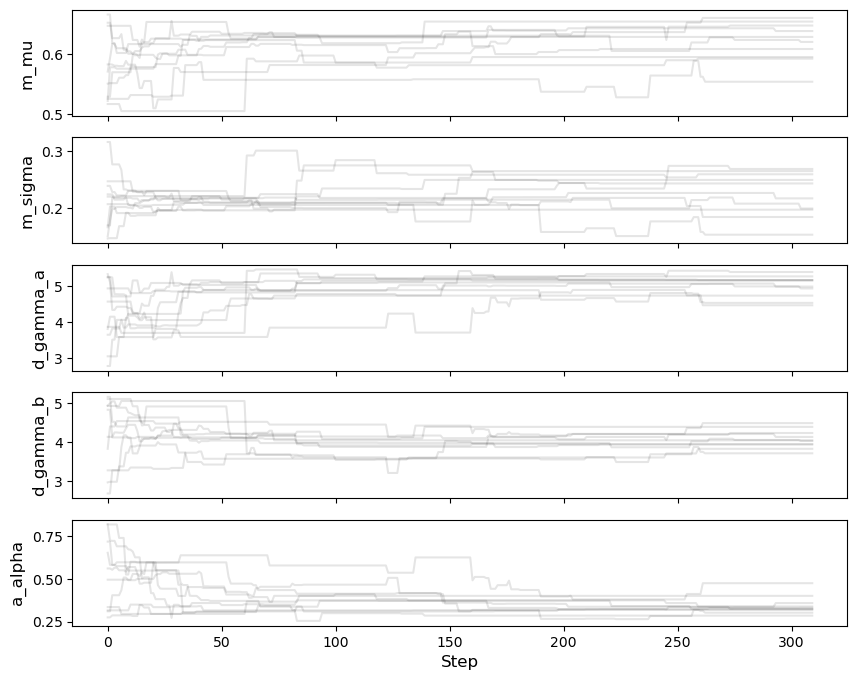

In [98]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

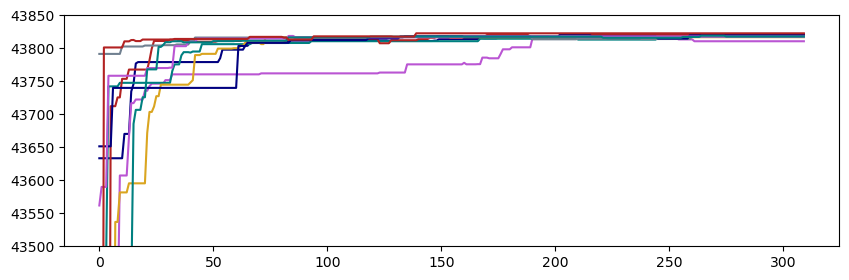

In [118]:
default_cycler=cycler(color=['navy','mediumorchid','teal','firebrick','goldenrod','slategrey'])
plt.rc('axes', prop_cycle=default_cycler)
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
plt.ylim(43500,43850)
plt.show()

In [100]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)

In [101]:
## check intrinsic scatter in the likelihood?
current_likes = []
current_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(current_state[i,:],return_spec=True)
    current_likes.append(like_i)
    current_astro.append(astro_i)

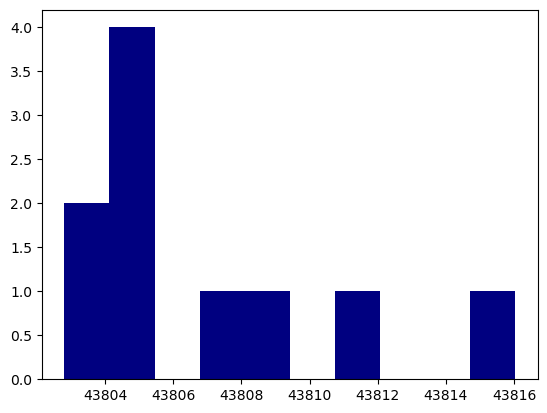

In [102]:
plt.figure()
plt.hist(current_likes)
plt.show()

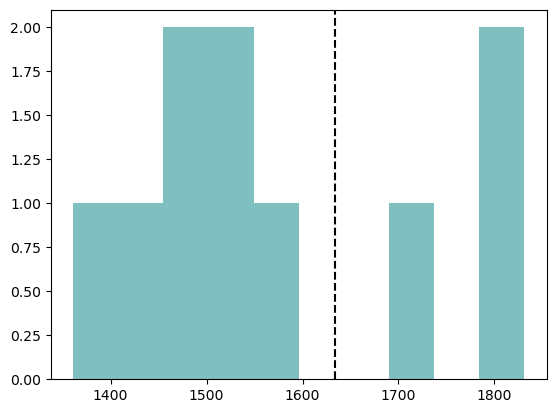

In [103]:
plt.figure()
plt.hist([current_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

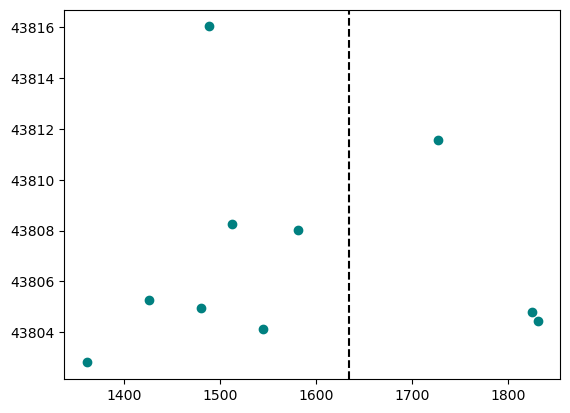

In [104]:
plt.figure()
plt.scatter([current_astro[i][2] for i in range(nwalkers)],current_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

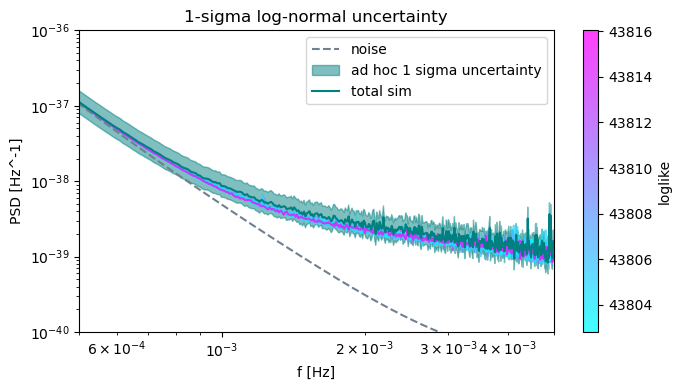

In [105]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()

plt.rcParams["axes.prop_cycle"] = get_cycle("cool", nwalkers)
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=current_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
plt.fill_between(total_fs,10**(np.log10(total_spec)-err),10**(np.log10(total_spec)+err),
                 color='teal',alpha=0.5,label='ad hoc 1 sigma uncertainty')
# plt.fill_between(total_fs,total_spec-err,total_spec+err,
#                  color='turquoise',alpha=0.5,label='ad hoc 1 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('1-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
plt.xlim(5e-4,5e-3)
plt.tight_layout()
plt.show()

In [107]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [108]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

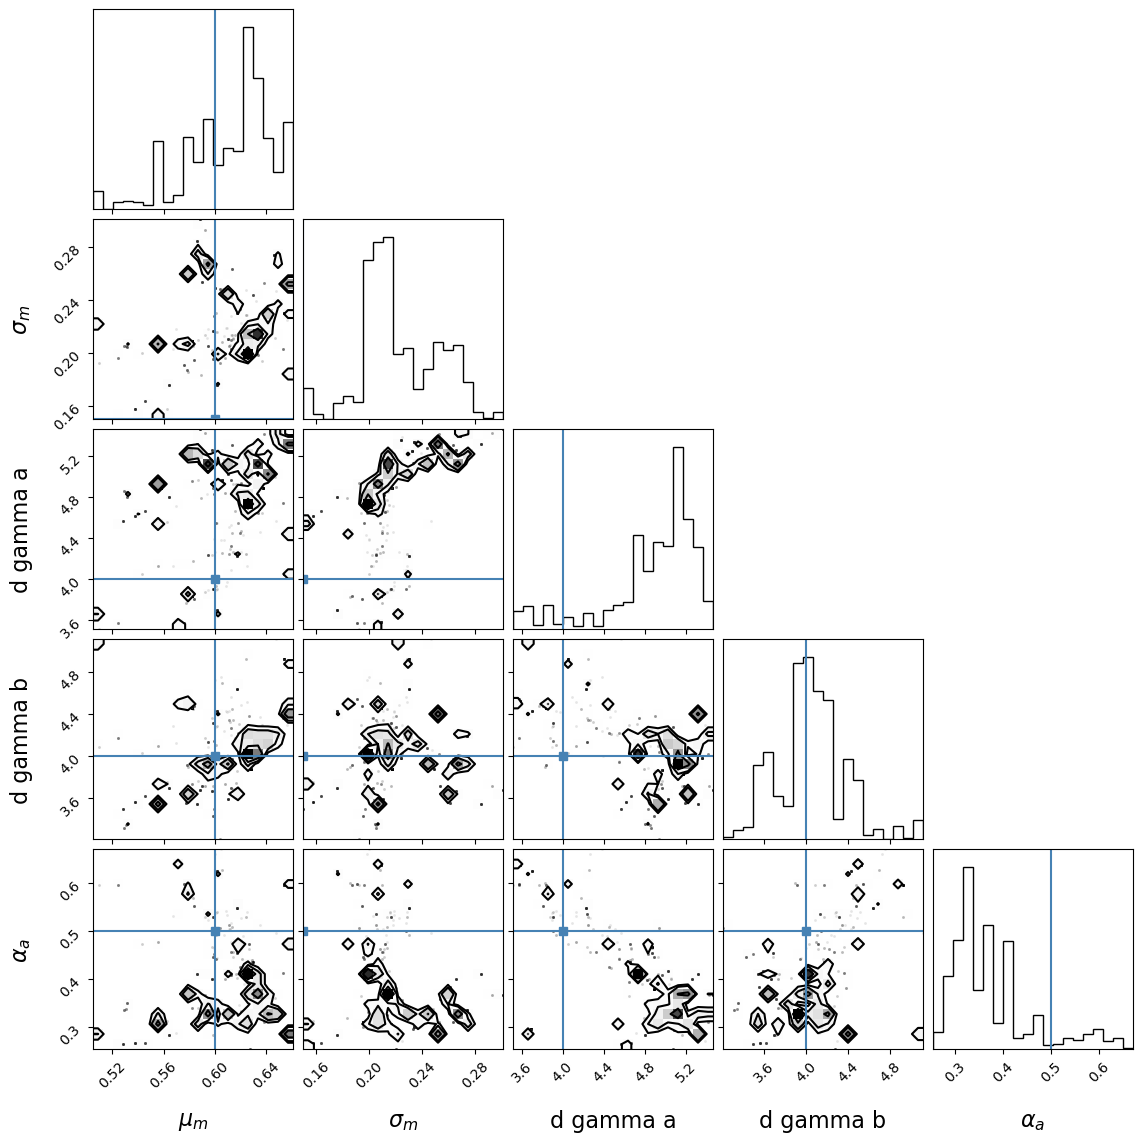

In [113]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)[100:,:]
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

Okay, cool. The mixed moves seems to be successful in allowing the walkers to move around the space. The stretch move is good at efficiently moving around the likelihood but can easily leave walkers stuck out of bounds; occasionally providing a prior draw proposal (which is very inefficient on its own) makes sure that any walkers stuck at -inf prior probability are brought back into the fold.

This is now working well enough that I'm seeing issues with the sampler trying to match to the spikiness of the data spectrum at higher frequencies, but fundamentally being unable to without improvements that we intend to do down the line (per-frequency parameterization of $\lambda_f$ and $N_f$, per-frequency uncertainty, etc.) This will interfere with our ability to make sure the initial toy model works as it currently exists. A few options to deal with this:

- Apply some sort of smoothing filter to the data spectrum to reduce spikiness. This may have the inadvertant effect of biasing the analysis towards populations with smoother spectra (i.e. fewer subthreshold sources), but this should at least partially be balanced out by the $N_{res}$ Poisson term.
- Dive right in and implement the above changes right now
- Further reduce the frequency range we consider, cutting out the problem area entirely.

I'm inclined to take the latter route for the moment; it should allow us to test the fidelity of the current model while avoiding further complications, and will have the nice side effect of greatly improving the speed of each test run.

In [53]:
nsteps = 5000
burn = None
thin_by = 1
out = ensemble.run_mcmc(out, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [9:47:09<00:00,  7.05s/it]


In [54]:
ensemble.acceptance_fraction

array([[0.00054054, 0.00126126, 0.0027027 , 0.00234234, 0.0009009 ,
        0.00144144, 0.0009009 , 0.0009009 , 0.0009009 , 0.00216216]])

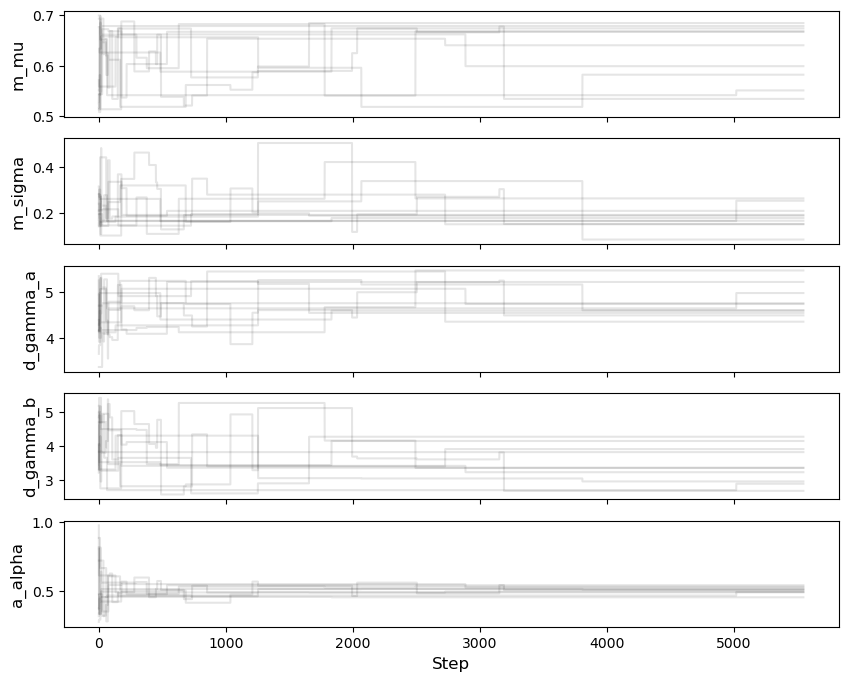

In [55]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

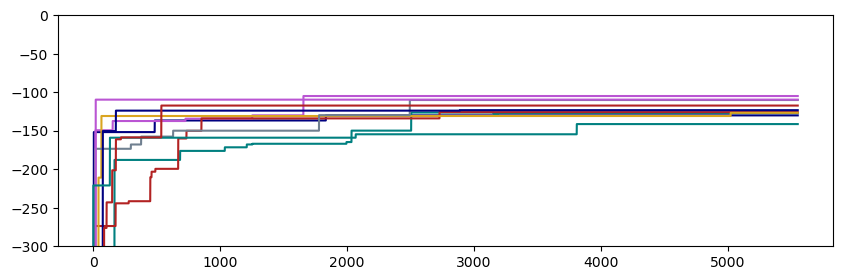

In [67]:
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],10)
plt.figure(figsize=(10,3))
for i in range(10):
    plt.plot(loglike[:,i])
plt.ylim(-300,0)
plt.show()

In [59]:
np.var(ensemble.get_chain()['model_0'].reshape(ensemble.get_chain()['model_0'].shape[0],10,5),axis=0)

array([[1.35193698e-03, 6.49956772e-04, 2.14992682e-02, 1.06054255e-01,
        6.94298532e-06],
       [1.33606323e-03, 2.50643837e-04, 7.80392793e-02, 3.51750208e-01,
        2.13530591e-04],
       [3.02891176e-03, 1.47768031e-02, 1.12491821e-01, 7.69997004e-01,
        1.81352853e-03],
       [1.31503923e-03, 6.65441324e-03, 2.57477949e-01, 1.98284178e-01,
        5.39620113e-04],
       [2.12091607e-04, 7.37357183e-04, 1.15127148e-02, 1.91873459e-02,
        4.97997130e-04],
       [2.12738873e-03, 5.03119297e-03, 3.60813658e-01, 5.93750334e-01,
        2.65418282e-04],
       [1.03128451e-03, 4.05948343e-04, 4.37977368e-02, 6.35457758e-02,
        4.71295718e-04],
       [7.59299109e-05, 1.17403183e-05, 2.01610085e-03, 1.39292843e-03,
        1.20600915e-04],
       [2.40437803e-03, 1.07420274e-02, 1.50463911e-01, 2.71259653e-01,
        3.59145507e-04],
       [5.29685693e-04, 4.02329071e-04, 9.79676458e-02, 6.19889806e-02,
        9.23384919e-04]])

In [60]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [61]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

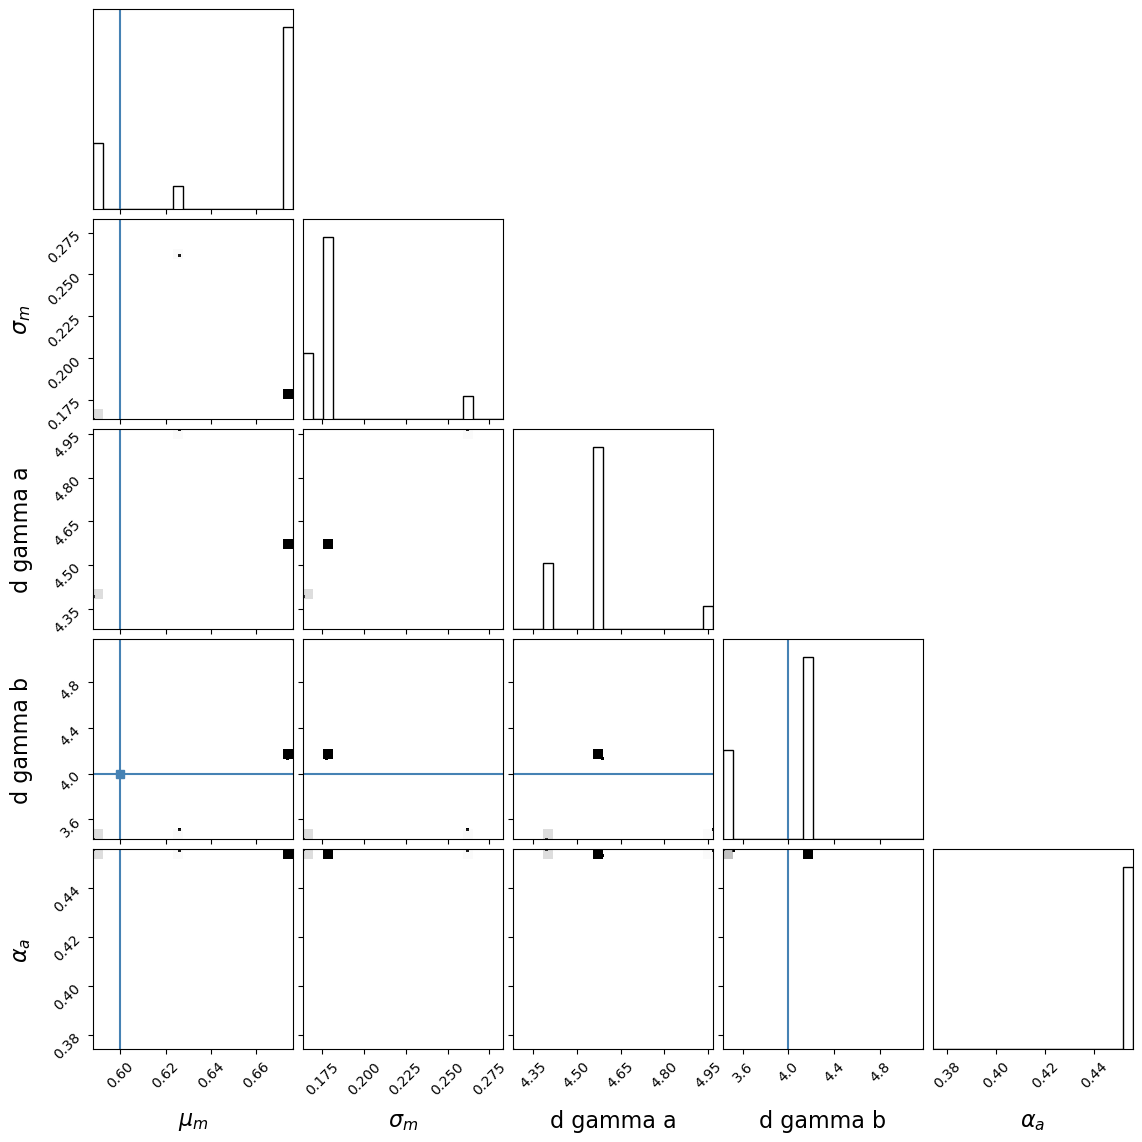

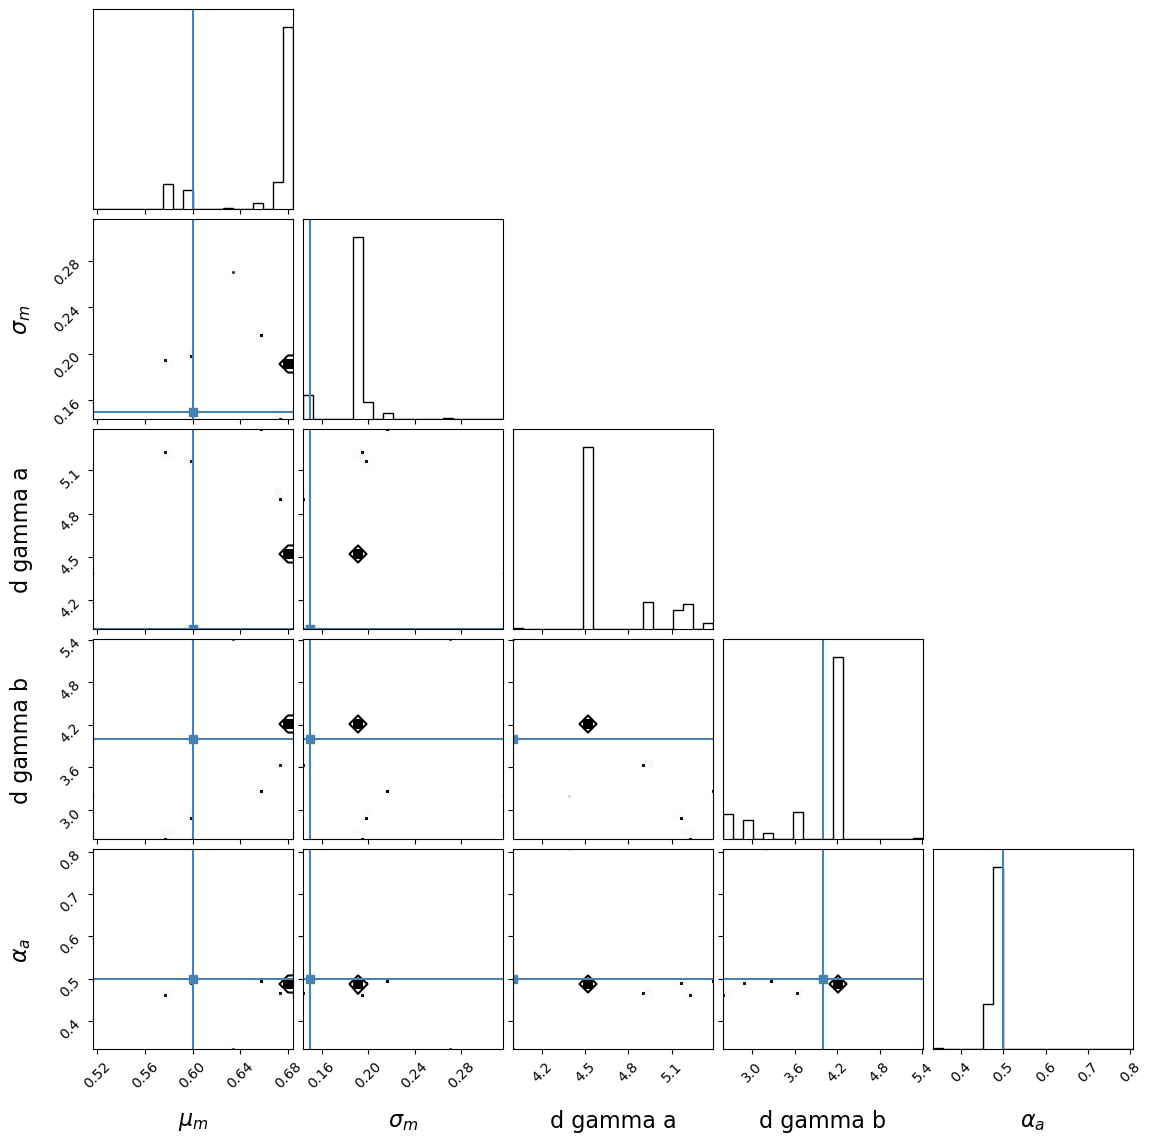

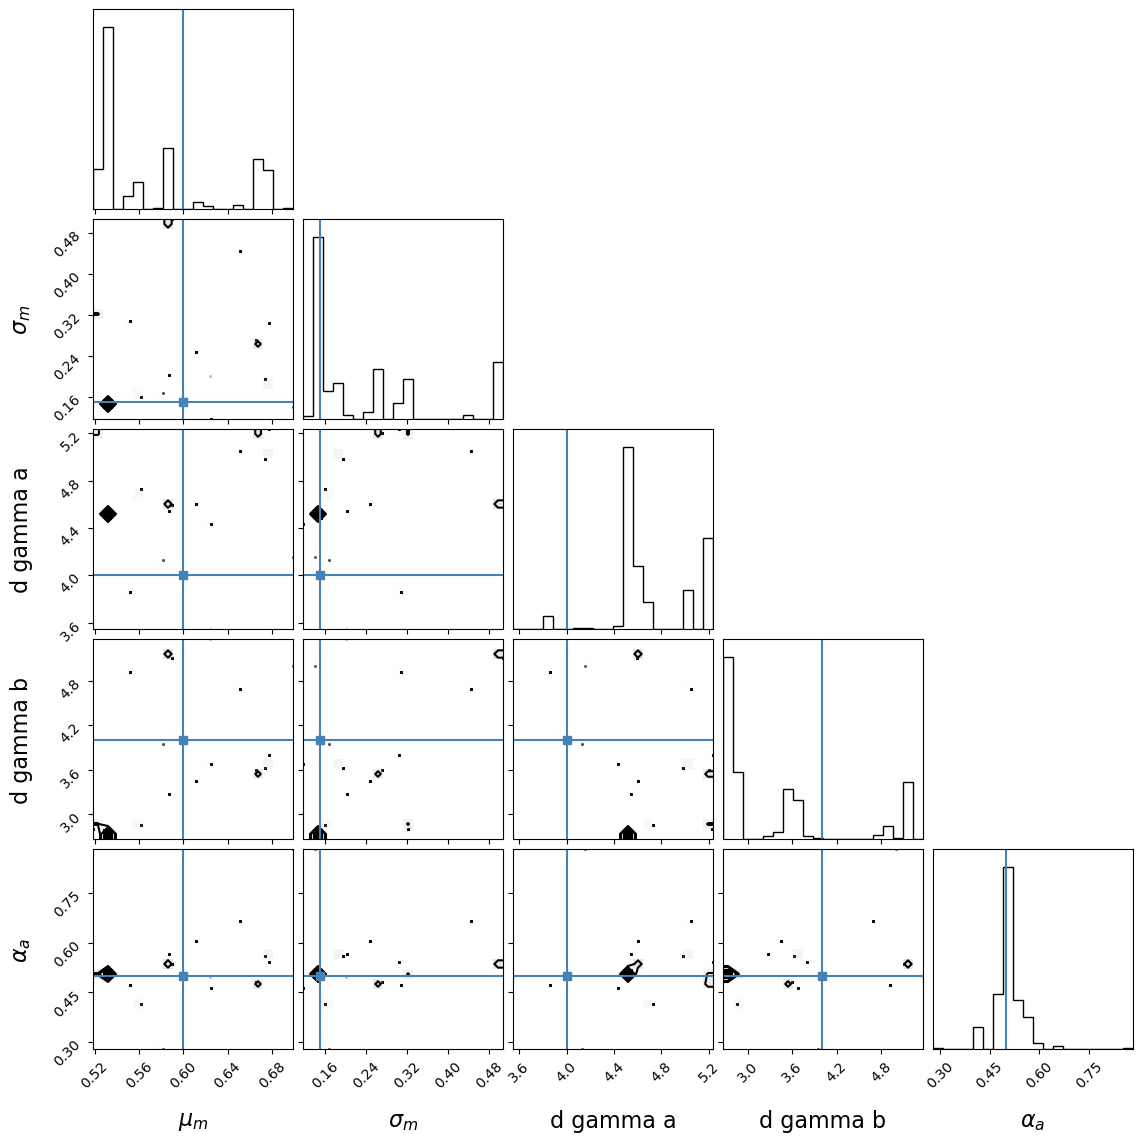

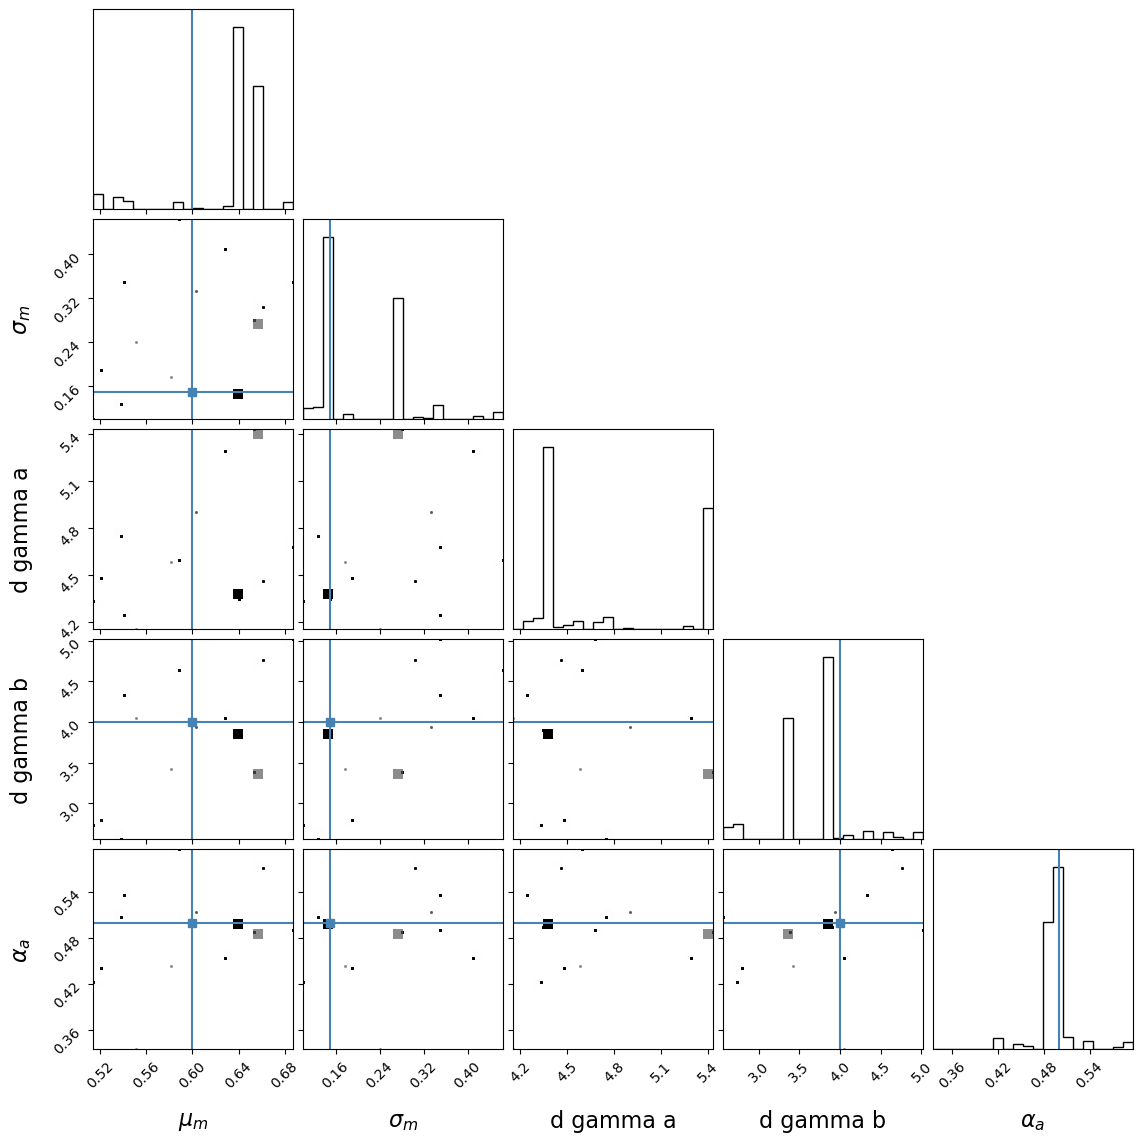

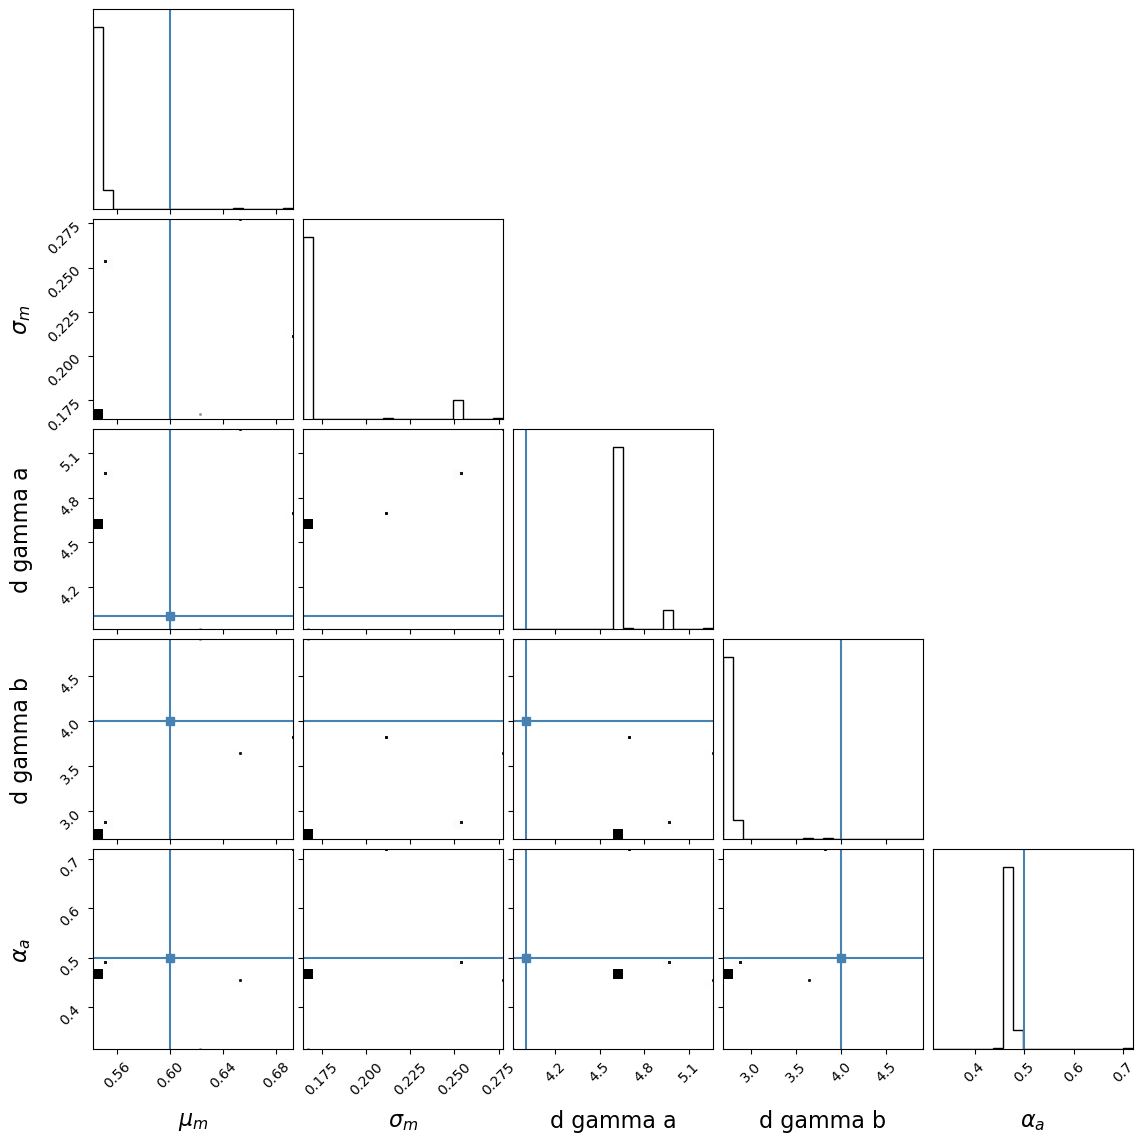

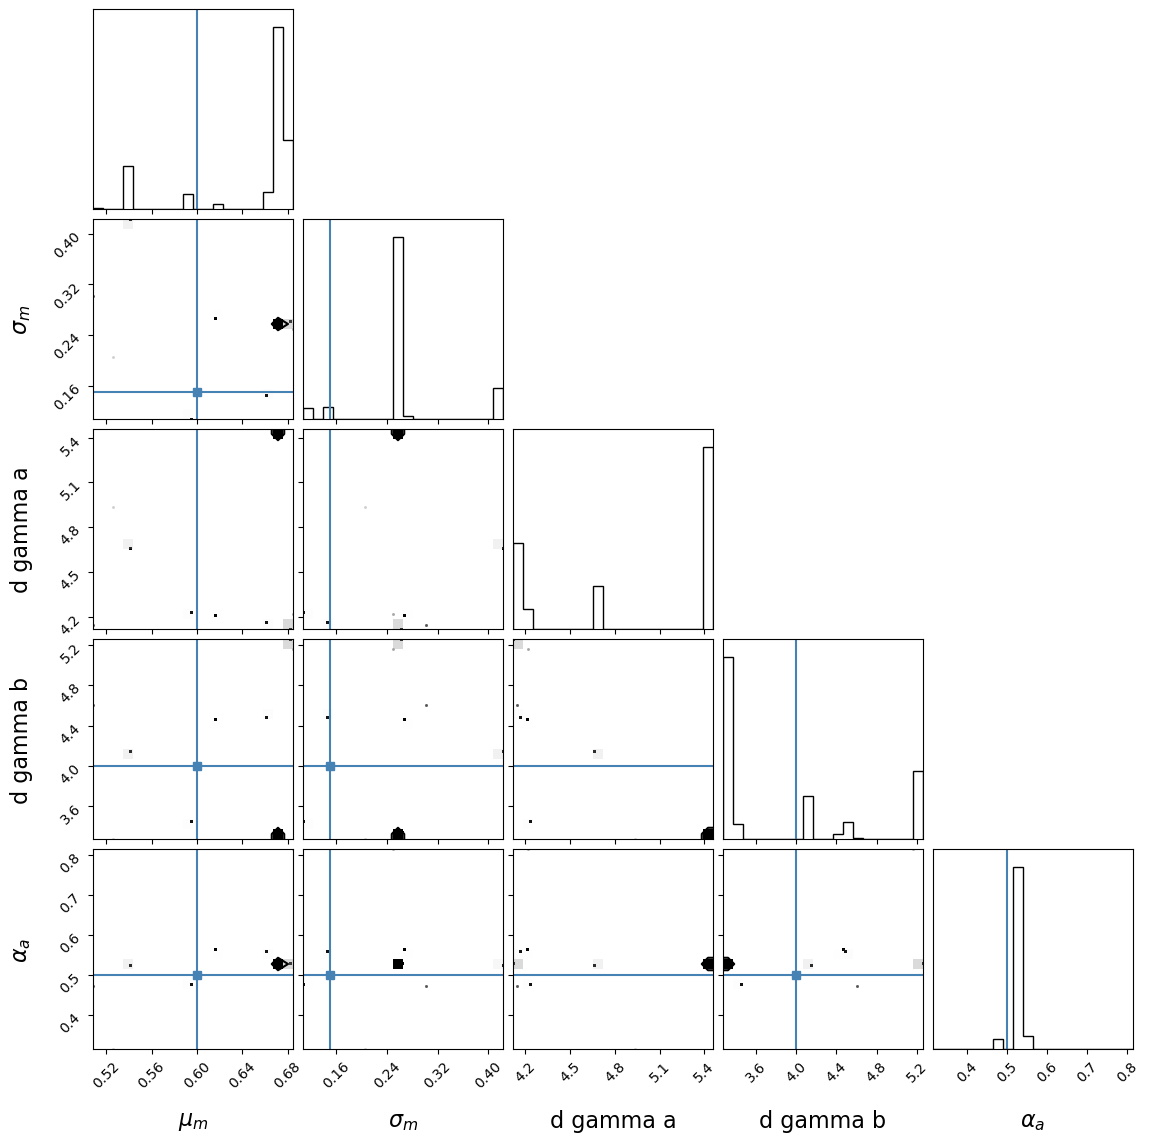

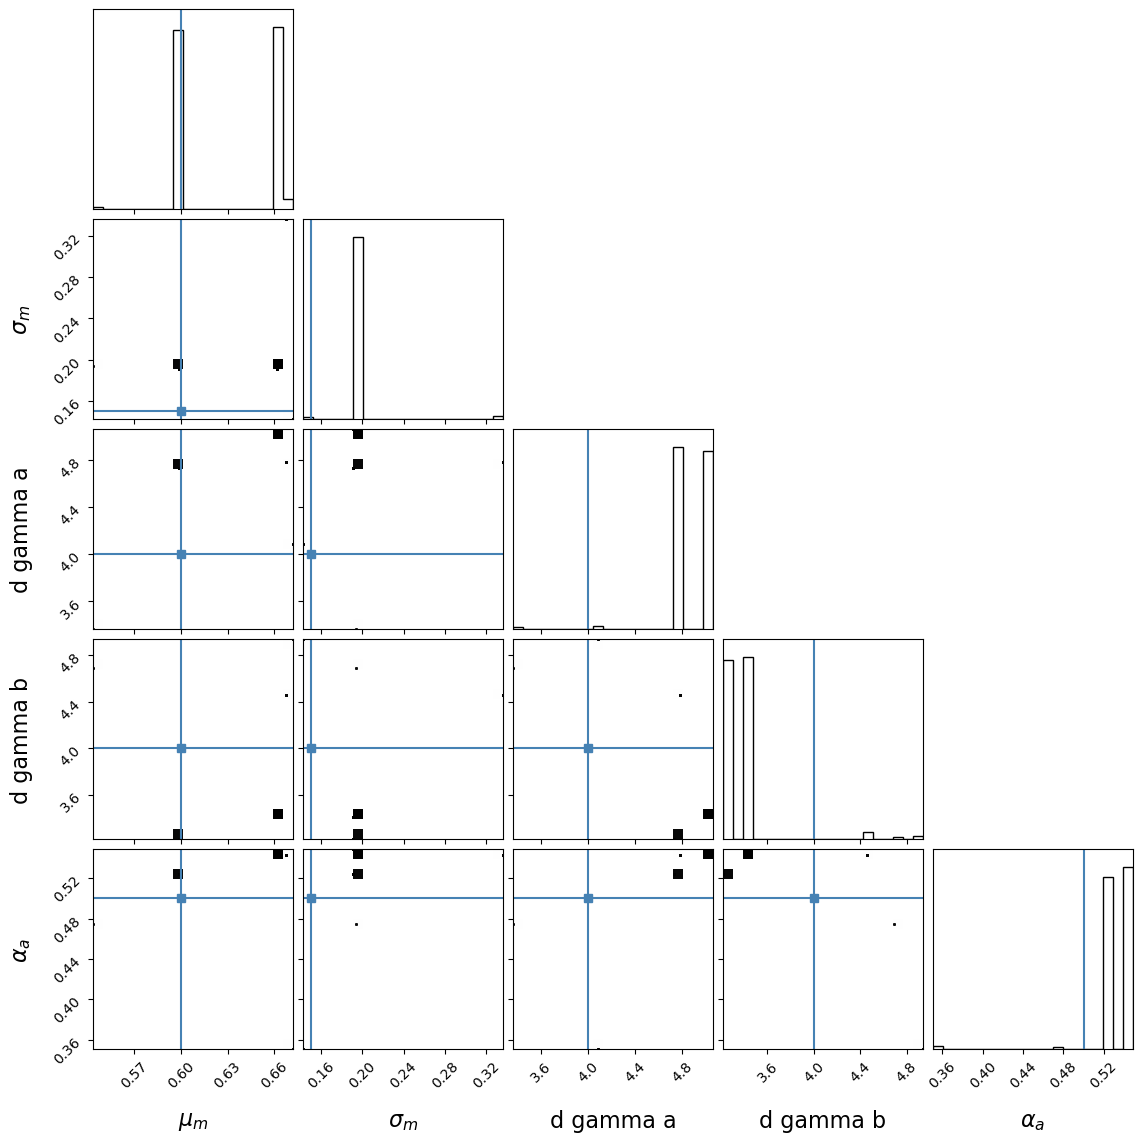

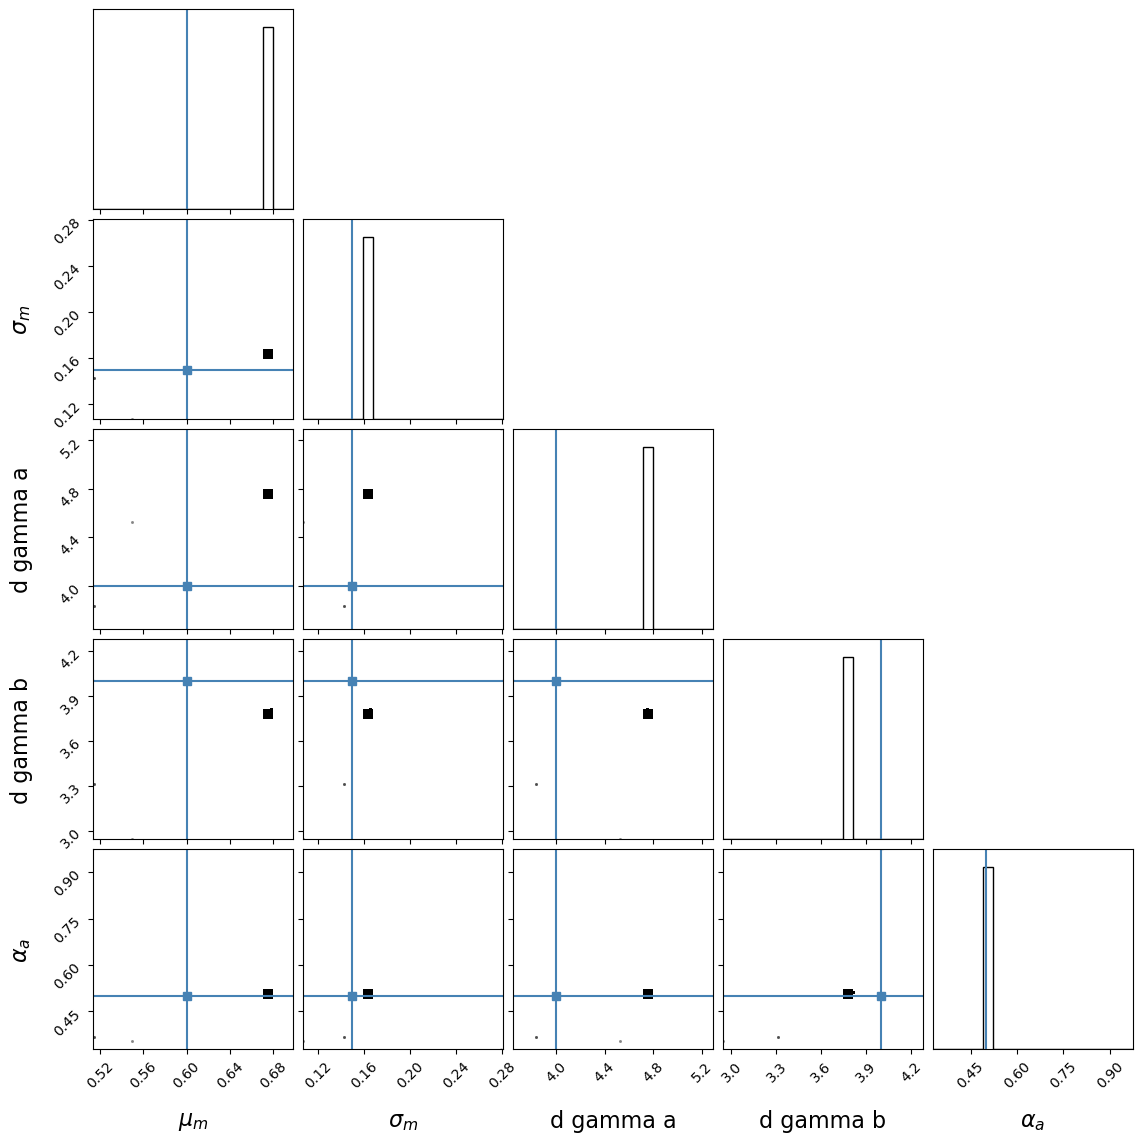

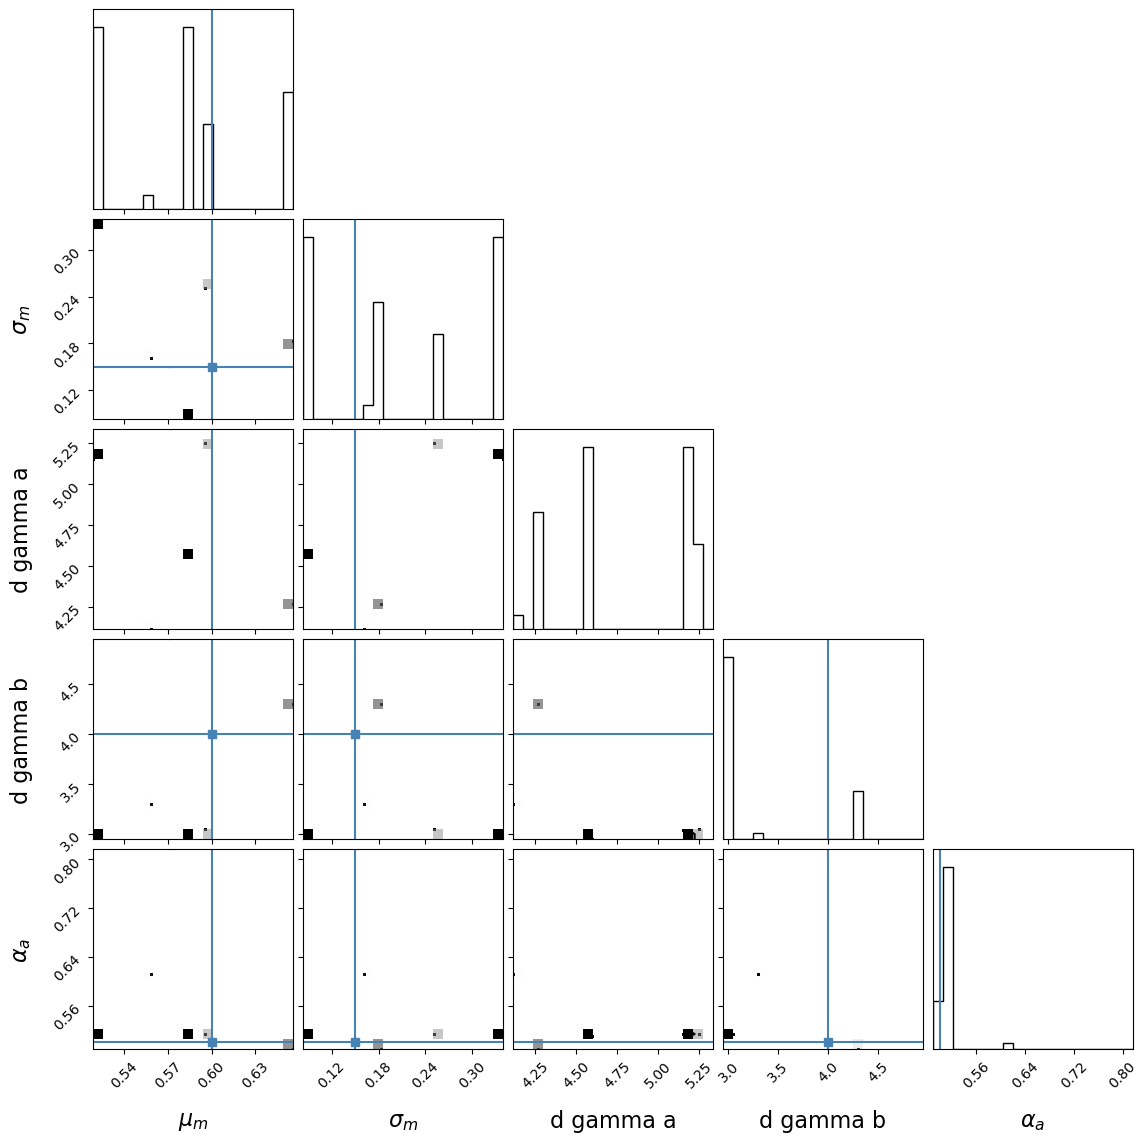

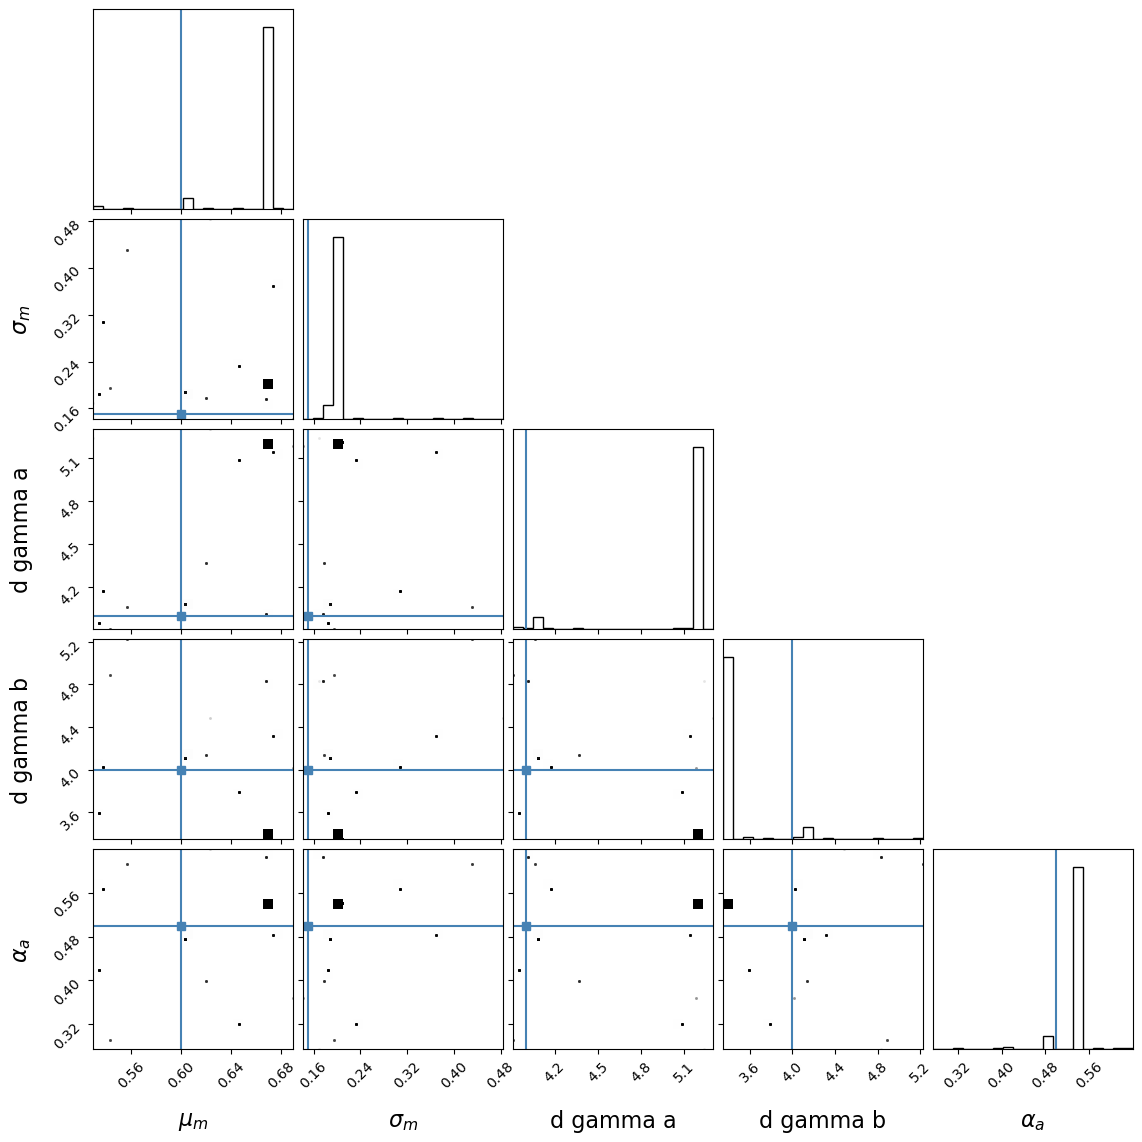

In [66]:
for i in range(10):
    plt.rcParams.update({'axes.labelsize':16})
    # samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
    samples = ensemble.get_chain()['model_0'].reshape(ensemble.get_chain()['model_0'].shape[0],10,5)[:,i,:]
    corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
    # plt.savefig('first_initial_result.png',dpi=200)
    plt.show()